# Module 7: APIs and Scraping

In today's module, we will learn about APIs and scraping.  

An API is an application programming interface. It provides a structured way to send commands or requests to a piece of software. "API" often refers to a web service API. This is like web site (but designed for applications, rather than humans, to use) that you can send requests to execute commands or query for data. To use them, you can send them a request, and they reply with a response, similar to how a web browser works. The request is sent to an endpoint (a URL) typically with a set of parameters to provide the details of your query or command.

Park. 2019. [How Do APIs Work?](https://tray.io/blog/how-do-apis-work) Tray.io.    

"Imagine you’re a customer at a restaurant. The waiter (the API) functions as an intermediary between customers like you (the user) and the kitchen (web server). You tell the waiter your order (API call), and the waiter requests it from the kitchen. Finally, the waiter will provide you with what you ordered." -- Park. 2019.  

Tools:  
1. [requests](https://docs.python-requests.org/en/master/): a Python packadge for retrieving web resources
2. [beautifulsoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/): a Python packadge for traversing and extracting elements from a web page HTML and XML files.

Today we are going to work through some examples of using API for requesting government data, and basic webscraping when API is not available:
* [Census Data API](#census)
* [Data Portals API](#local)
* [Web scraping](#scraping)

(Side note: I'm demoing a clickable table of contents here. Give it a look to see how to do this in markdown.)

In [1]:
from bs4 import BeautifulSoup
import requests

import pandas as pd
import seaborn as sns

import time
import json
import re

<a id='census'></a>
## 1. Census Data API

Traditionally, you may search, access and download census data from the website like [data.census.gov](https://data.census.gov/cedsci/). The U.S. Census Bureau provides [Census Data API](https://www.census.gov/data/developers/guidance/api-user-guide.Overview.html) to allow users to query data directly from Census Bureau servers. The Census Data API is a more efficient and flexible way to query large amount of data for target variables and geographies, compared to traditional webpage interface. 

To follow along with this sction, you need a working API key to use the Census API Service. You can register for an API key, free of charge by following these steps: 
  1. Go to the [Developers site](https://www.census.gov/data/developers.html)
  2. Click on the Request a KEY box on the left side of the page.
  3. Fill out the pop-up window form.
  4. You will receive an email with your key code in the message and a link to register it.
  5. Then save your unique key code in a Python script named `keys.py` with information like `census_api_key = 'your-key-code'`
  

In [2]:
# import your KEY inforamtion
# The following code imports only the census_api_key variable from the keys module:
from keys import census_api_key

In [3]:
# which census dataset, in this example, we use ACS 1-year estimate profile dataset
dataset = 'acs/acs1/profile'

# which census variables to retrieve
variables = {'DP05_0033E' : 'tot_pop',
            'DP05_0071E' : 'hispanic',
            'DP05_0044E' : 'asian',
            'DP05_0037E' : 'white',
            'DP05_0038E' : 'black'}

# the data year your want to query 
year = 2019

# the api key you get from the Census
api_key = census_api_key

You need to know the census dataset file well for requesting data via their API service:  
- Variables you can query for from ACS: https://api.census.gov/data/2017/acs/acs5/profile/variables.html
https://api.census.gov/data/2017/acs/acs5/subject/variables.html


In [4]:
# convert vars to string to send to api
variables_str = ','.join(variables)
variables_str

'DP05_0033E,DP05_0071E,DP05_0044E,DP05_0037E,DP05_0038E'

In [5]:
# in this case, we want to obtain total population for all variables in all US metropolitan and micropolitan statistical areas
url_template = 'https://api.census.gov/data/{year}/{dataset}?' \
           'get=NAME,{variable}&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*&key={api_key}'

url = url_template.format(year=year, dataset=dataset, variable=variables_str, api_key=api_key)

In [6]:
# take a look at the url to see what data you are expecting 
#url

You can check the example url for acs data: https://api.census.gov/data/2019/acs/acs1/examples.html, in this case we focus on the metropolitan area example.

In [7]:
# request the data by sending a get request
response = requests.get(url, timeout=30)

# parse the json string into a Python dict
json_data = response.json()

[JSON](https://en.wikipedia.org/wiki/JSON) is a standardized format the community uses to pass data around. People often use JSON to store and exchange data in websites (they look a lot like looks like a Python dictionary format). But keep in mind, JSON isn’t the only format available for this kind of work, other common ones include XML and YAML.

In [8]:
#type(response)
#response.status_code
#print(response.text)
#json_data

In [9]:
# load as dataframe
df = pd.DataFrame(json_data)
df.head()

,0,1,2,3,4,5,6
0,NAME,DP05_0033E,DP05_0071E,DP05_0044E,DP05_0037E,DP05_0038E,metropolitan statistical area/micropolitan sta...
1,"Aberdeen, WA Micro Area",75061,7745,961,65316,1890,10140
2,"Abilene, TX Metro Area",171795,43037,2993,139995,14998,10180
3,"Adrian, MI Micro Area",98451,8049,361,92654,1889,10300
4,"Aguadilla-Isabela, PR Metro Area",288877,275115,0,220263,6501,10380


In [10]:
#df.rename(columns=df.iloc[0])

In [11]:
# set the first row as column name
df = df.rename(columns=df.iloc[0]).drop(df.index[0])
df.head()

,NAME,DP05_0033E,DP05_0071E,DP05_0044E,DP05_0037E,DP05_0038E,metropolitan statistical area/micropolitan statistical area
1,"Aberdeen, WA Micro Area",75061,7745,961,65316,1890,10140
2,"Abilene, TX Metro Area",171795,43037,2993,139995,14998,10180
3,"Adrian, MI Micro Area",98451,8049,361,92654,1889,10300
4,"Aguadilla-Isabela, PR Metro Area",288877,275115,0,220263,6501,10380
5,"Akron, OH Metro Area",703479,15607,21443,567593,88492,10420


In [12]:
# let's rename the dataset to a more intuitive column name
df = df.rename(columns=variables)
df.head()

,NAME,tot_pop,hispanic,asian,white,black,metropolitan statistical area/micropolitan statistical area
1,"Aberdeen, WA Micro Area",75061,7745,961,65316,1890,10140
2,"Abilene, TX Metro Area",171795,43037,2993,139995,14998,10180
3,"Adrian, MI Micro Area",98451,8049,361,92654,1889,10300
4,"Aguadilla-Isabela, PR Metro Area",288877,275115,0,220263,6501,10380
5,"Akron, OH Metro Area",703479,15607,21443,567593,88492,10420


In [13]:
def get_census_variableprofile_descriptions(dataset, year, variables):
    """Download descriptions of census variables from the API
    """
    url_template = 'https://api.census.gov/data/{year}/{dataset}/profile/variables/{variable}.json'
    variable_descriptions = {}
    
    for variable in variables:
        url = url_template.format(year=year, dataset=dataset, variable=variable)
        response = requests.get(url)
        data = response.json()
        variable_descriptions[variable] = {'concept':data['concept'],
                                           'label':data['label']}

    return variable_descriptions

In [14]:
# download and display census descriptions of each variable
variable_descriptions = get_census_variableprofile_descriptions(dataset='acs/acs1', 
                                                            year=year, 
                                                            variables=variables)

for v, d in variable_descriptions.items():
    print('{}\t{}'.format(variables[v], d['label']))

tot_pop	Estimate!!RACE!!Total population
hispanic	Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!Hispanic or Latino (of any race)
asian	Estimate!!RACE!!Total population!!One race!!Asian
white	Estimate!!RACE!!Total population!!One race!!White
black	Estimate!!RACE!!Total population!!One race!!Black or African American


The Census provides very well documented API user guide, check on [Example API queries page](https://www.census.gov/data/developers/guidance/api-user-guide.Example_API_Queries.html), and feel free to experiment and query [available data](https://www.census.gov/data/developers/guidance/api-user-guide.Available_Data.html) on your own.



<a id='local'></a>
## 2. Data Portals

Many governments and agencies now open up their data to the public through a data portal. These often offer APIs to query them for real-time data. 

Using the Cambridge Open Data Portal... browse the portal for public datasets: https://data.cambridgema.gov/browse

First we'll look at crime report data in Cambridge: https://data.cambridgema.gov/Public-Safety/Crime-Reports/xuad-73uj

### 2.1. Crime report


In [15]:
# define API endpoint
endpoint_url = 'https://data.cambridgema.gov/resource/xuad-73uj.json'

# request the URL and download its response
response = requests.get(endpoint_url)

# parse the json string into a Python dict
data = response.json()

In [16]:
len(data)

1000

There are more than 1000 rows in the dataset, but we're limited by the API to only 1000 per request. We have to use pagination to get the rest.

In [17]:
# recursive function to keep requesting more rows until there are no more
def request_data(endpoint_url, limit=1000, offset=0, data=[]):
    """Request all data from the API until there are no more
    """
    url = endpoint_url + '?$limit={limit}&$offset={offset}'
    request_url = url.format(limit=limit, offset=offset)
    response = requests.get(request_url)
    
    rows = response.json()
    data.extend(rows)
    
    if len(rows) >= limit:
        data = request_data(endpoint_url, offset=offset+limit, data=data)

    return data

In [18]:
# get all the data from the API, using our recursive function
endpoint_url = 'https://data.cambridgema.gov/resource/xuad-73uj.json'
data = request_data(endpoint_url)
len(data)

76092

In [19]:
# turn the json data into a dataframe
df = pd.DataFrame(data)
df.shape

(76092, 7)

In [20]:
# what columns are in our data?
df.columns

Index(['file_number', 'date_of_report', 'crime_date_time', 'crime',
       'reporting_area', 'neighborhood', 'location'],
      dtype='object')

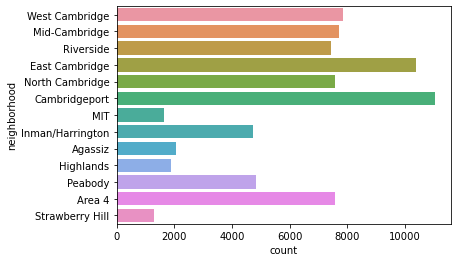

In [21]:
#count and plot the number of crime by neighborhood
ax = sns.countplot(data=df, y='neighborhood')


You can use any web service's API in this same basic way: request the URL with some parameters. Read the API's documentation to know how to use it and what to send. You can also use many web service's through a Python package to make complex services easier to work with. For example, there's a fantastic package called [cenpy](https://cenpy-devs.github.io/cenpy/) that makes downloading and working with US census data super easy.

<a id='scraping'></a>

## 3. Web Scraping

If you need data from a web page that doesn't offer an API, you can scrape it. Note that many web sites prohibit scraping in their terms of use, so proceed respectfully and cautiously. Web scraping means downloading a web page, parsing individual data out of its HTML, and converting those data into a structured dataset.

For straightforward web scraping tasks, you can use the powerful [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) package, but it may not work for some other complex web pages...

In this example, we'll scrape https://en.wikipedia.org/wiki/List_of_National_Basketball_Association_arenas  

The first step in scraping is figuring out a way to identify the information you want.

In [22]:
url = 'https://en.wikipedia.org/wiki/List_of_National_Basketball_Association_arenas'
response = requests.get(url)
html = response.text

In [23]:
# look at the html string
html[5000:7000]

'="/w/index.php?title=List_of_National_Basketball_Association_arenas&amp;action=edit"/>\n<link rel="edit" title="Edit this page" href="/w/index.php?title=List_of_National_Basketball_Association_arenas&amp;action=edit"/>\n<link rel="apple-touch-icon" href="/static/apple-touch/wikipedia.png"/>\n<link rel="shortcut icon" href="/static/favicon/wikipedia.ico"/>\n<link rel="search" type="application/opensearchdescription+xml" href="/w/opensearch_desc.php" title="Wikipedia (en)"/>\n<link rel="EditURI" type="application/rsd+xml" href="//en.wikipedia.org/w/api.php?action=rsd"/>\n<link rel="license" href="//creativecommons.org/licenses/by-sa/3.0/"/>\n<link rel="canonical" href="https://en.wikipedia.org/wiki/List_of_National_Basketball_Association_arenas"/>\n<link rel="dns-prefetch" href="//login.wikimedia.org"/>\n<link rel="dns-prefetch" href="//meta.wikimedia.org" />\n</head>\n<body class="mediawiki ltr sitedir-ltr mw-hide-empty-elt ns-0 ns-subject mw-editable page-List_of_National_Basketball_A

You could manually search for the text and extract them but it would be really cumbersome.   

The BeautifulSoup makes this much easier by converting the text into a data structure that is easy to “traverse”

In [24]:
# parse the html
soup = BeautifulSoup(html, features='html.parser')
#soup

In [25]:
# use the find_all() function to find all tags of a paticular type
# in this case, we find all the table body, then we find all table row within the table body
rows = soup.find('tbody').findAll('tr')
#rows
rows[1]

<tr>
<td><a class="image" href="/wiki/File:St_Pete_Times_Forum_At_Sunset.jpg"><img alt="St Pete Times Forum At Sunset.jpg" data-file-height="1110" data-file-width="2046" decoding="async" height="65" src="//upload.wikimedia.org/wikipedia/commons/thumb/2/2a/St_Pete_Times_Forum_At_Sunset.jpg/120px-St_Pete_Times_Forum_At_Sunset.jpg" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/2/2a/St_Pete_Times_Forum_At_Sunset.jpg/180px-St_Pete_Times_Forum_At_Sunset.jpg 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/2/2a/St_Pete_Times_Forum_At_Sunset.jpg/240px-St_Pete_Times_Forum_At_Sunset.jpg 2x" width="120"/></a>
</td>
<td><b><a href="/wiki/Amalie_Arena" title="Amalie Arena">Amalie Arena</a></b><sup class="reference" id="cite_ref-a_2-0"><a href="#cite_note-a-2">[a]</a></sup>
</td>
<td><a href="/wiki/Tampa,_Florida" title="Tampa, Florida">Tampa, Florida</a>
</td>
<td><a href="/wiki/Toronto_Raptors" title="Toronto Raptors">Toronto Raptors</a>
</td>
<td align="center">20,500
</td>
<td align

[HTML Table](https://www.w3schools.com/html/html_tables.asp): `<tbody>` groups the body content in a table. Each table row is defined with a `<tr>` tag. Each table header is defined with a `<th>` tag. Each table data/cell is defined with a `<td>` tag.

In [26]:
data = []
for row in rows[1:]:
    cells = row.findAll('td') 
    d = [cell.text.strip('\n') for cell in cells[1:-1]] #The '\n' character is used to find a newline character.
    #print(cells[1:-1])
    #print(d)
    data.append(d)
#data

In [27]:
cols = ['arena', 'city', 'team', 'capacity', 'opened']
df = pd.DataFrame(data=data, columns=cols).dropna()
df

,arena,city,team,capacity,opened
0,Amalie Arena[a],"Tampa, Florida",Toronto Raptors,"20,500",1996
1,American Airlines Center,"Dallas, Texas",Dallas Mavericks,"19,200",2001
2,Amway Center,"Orlando, Florida",Orlando Magic,"18,846",2010
3,AT&T Center,"San Antonio, Texas",San Antonio Spurs,"18,418",2002
4,Ball Arena,"Denver, Colorado",Denver Nuggets,"19,520",1999
5,Bankers Life Fieldhouse,"Indianapolis, Indiana",Indiana Pacers,"17,923",1999
6,Barclays Center,"Brooklyn, New York",Brooklyn Nets,"17,732",2012
7,Capital One Arena,"Washington, D.C.",Washington Wizards,"20,356",1997
8,Chase Center,"San Francisco, California",Golden State Warriors,"18,064",2019
9,Chesapeake Energy Arena,"Oklahoma City, Oklahoma",Oklahoma City Thunder,"18,203",2002


In [28]:
# strip out all the wikipedia notes in square brackets
# The applymap() function is used to apply a function to every elements in a Dataframe
# lambda functions let you write write functions in a quick way
# We can pass lambda function to the applymap() without even naming them, like an anonymous functions.
# the re module provide regular experssion matching in Python
df = df.applymap(lambda x: re.sub(r'\[.\]', '', x))
df

,arena,city,team,capacity,opened
0,Amalie Arena,"Tampa, Florida",Toronto Raptors,"20,500",1996
1,American Airlines Center,"Dallas, Texas",Dallas Mavericks,"19,200",2001
2,Amway Center,"Orlando, Florida",Orlando Magic,"18,846",2010
3,AT&T Center,"San Antonio, Texas",San Antonio Spurs,"18,418",2002
4,Ball Arena,"Denver, Colorado",Denver Nuggets,"19,520",1999
5,Bankers Life Fieldhouse,"Indianapolis, Indiana",Indiana Pacers,"17,923",1999
6,Barclays Center,"Brooklyn, New York",Brooklyn Nets,"17,732",2012
7,Capital One Arena,"Washington, D.C.",Washington Wizards,"20,356",1997
8,Chase Center,"San Francisco, California",Golden State Warriors,"18,064",2019
9,Chesapeake Energy Arena,"Oklahoma City, Oklahoma",Oklahoma City Thunder,"18,203",2002


In [29]:
# convert capacity and opened to integer
df['capacity'] = df['capacity'].str.replace(',', '')
df[['capacity', 'opened']] = df[['capacity', 'opened']].astype(int)

In [30]:
df.sort_values('capacity', ascending=False)

,arena,city,team,capacity,opened
28,United Center,"Chicago, Illinois",Chicago Bulls,20917,1994
0,Amalie Arena,"Tampa, Florida",Toronto Raptors,20500,1996
30,Wells Fargo Center,"Philadelphia, Pennsylvania",Philadelphia 76ers,20478,1996
7,Capital One Arena,"Washington, D.C.",Washington Wizards,20356,1997
14,Little Caesars Arena,"Detroit, Michigan",Detroit Pistons,20332,2017
15,Madison Square Garden,"New York City, New York",New York Knicks,19812,1968
19,Scotiabank Arena,"Toronto, Ontario",Toronto Raptors,19800,1999
12,FTX Arena,"Miami, Florida",Miami Heat,19600,1999
4,Ball Arena,"Denver, Colorado",Denver Nuggets,19520,1999
16,Moda Center,"Portland, Oregon",Portland Trail Blazers,19441,1995


Web scraping is really hard! You need to understand the website structure well and it takes lots of practice. If you want to use it, read the BeautifulSoup and Selenium documentation carefully, follow examples, and then practice, practice, practice. You'll be an expert before long.

## This week's assignment

Starting this week, you will start thinking about your final project. You are asked to submit a final project proposal following the instruction posted on course website, and also submit at least one dataset you want to use for your final project, from data APIs, public data portals, FTP servers, or directly from an organization etc.  

The very first step you need to do is to think about a topic that interests you and explore useful dataset. Below are some datasets for your inspiration.   

## Data sources, API, data repository for inspiration:
- US Census and Geographies
    - American Community Survey, county business pattern, or Decennial Census data you can download from [data.census.gov](https://data.census.gov/cedsci/); request via [Census Data API](https://www.census.gov/data/developers/guidance/api-user-guide.Overview.html); or via  [cenpy](https://cenpy-devs.github.io/cenpy/)
    - [IPUMS Census and Survey Data](https://ipums.org/): a great data repository for standardize census microdata across time and space, and other health survey and GIS data from around the world
    - Census geospatial data products from [TIGER](https://www.census.gov/cgi-bin/geo/shapefiles/index.php), or from Census API [censusviz package](https://pypi.org/project/censusviz/)
- US economic data:
    - [Bureau of Labor Statistics](https://www.bls.gov/developers/) for employment and labor market data
    - [Bureau of Economic Analysis](https://www.bea.gov/data) for GDP, income, industrial data etc.
    - [Clustering Mapping Project](https://clustermapping.us/region) if you are doing regional economic analysis
- US local open data portals:
    - [Cambridge](https://data.cambridgema.gov/browse)
    - [Boston](https://data.boston.gov/); Boston Data Portal from [BARI](https://cssh.northeastern.edu/bari/boston-data-portal/)
    - [Chicago](https://data.cityofchicago.org/)
    - [New York](https://data.cityofnewyork.us/browse?provenance=official&sortBy=most_accessed&utf8=%E2%9C%93)
    - [San Francisco](https://datasf.org/opendata/developers/)
    - [Los Angeles](https://data.lacity.org/browse)
    
- U.S. DEPARTMENT OF AGRICULTURE ([USDA](https://www.ers.usda.gov/data-products/)) has great natural resources, environment, food and economic data
- [National Longitudinal Survey of Youth](https://www.nlsinfo.org/content/cohorts) if you are interested in youth development
- [FBI Crime Data](https://crime-data-explorer.fr.cloud.gov/), including an API (can be used for geospatial analyses)
- Global indicator repository for health, sustainability, environment, and urban developemnt indicators around the world:
    - [World Bank Development Indicators](https://datahelpdesk.worldbank.org/knowledgebase/topics/125589)
    - [WHO Global Health Observatory](https://apps.who.int/gho/data/node.home)
    - [UN Habitat Urban Indicators Database](https://data.unhabitat.org/)
    - [The Data-Driven EnviroLab](https://datadrivenlab.org/urban/)
  
- List of APIs from [Data.gov](https://api.data.gov/list-of-apis/)
    
- Other APIs you may be interested:
    - [Twitter API](https://developer.twitter.com/en/docs)
    - [google map API](https://developers.google.com/maps/documentation/)
    - [National Weather Service API](https://www.weather.gov/documentation/services-web-api)
    - [OpenStreetMap](https://www.openstreetmap.org/#map=5/38.007/-95.844) offers geospatial data worldwide, you can request via [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API), or via python packadge [OSMnx](https://github.com/gboeing/osmnx)
    - [New York Times API](https://developer.nytimes.com/apis)

Also check out some examples notebooks from https://github.com/jupyter/jupyter/wiki/A-gallery-of-interesting-Jupyter-Notebooks#machine-learning-statistics-and-probability and https://anaconda.org/gallery for inspiration to help you move towards final project